# Data analysis

Import necessary libraries

In [3]:
!pip install geocoder 
!python -m pip install folium
!pip install foursquare
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 102kB 8.9MB/s ta 0:00:011
     |████████████████████████████████| 102kB 7.7MB/s ta 0:00:011
Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 10000 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue ID, venue name and category.

In [133]:
import os
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=10000
    CLIENT_ID = 'MUYSCLH2B0FLTAHPFVHL0TSKHLPTLZSVBPEKGT0RXA4Z4RL4' # your Foursquare ID
    CLIENT_SECRET = 'CTE3PEN4HKCKNDK1N4YVUJM1S4SF2IBHB05ZDXRGGV5XLFO1' # your Foursquare Secret
    VERSION = '20200701' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data = results['response']['groups'][0]['items']
    venue_details = []
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count, rating, tip counts for a given venue ID. This will be used for ranking.

In [123]:
def get_venue_details(venue_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    CLIENT_ID = ['MUYSCLH2B0FLTAHPFVHL0TSKHLPTLZSVBPEKGT0RXA4Z4RL4'] # your Foursquare CLIENT_ID
    CLIENT_SECRET = ['CTE3PEN4HKCKNDK1N4YVUJM1S4SF2IBHB05ZDXRGGV5XLFO1'] # your Foursquare Secret
    VERSION = '20200701' # Foursquare API version
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a function to get the New York City data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the New York City data.

In [8]:
# get new york data
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

This indicates that there are total of 306 different neighborhoods in New York.

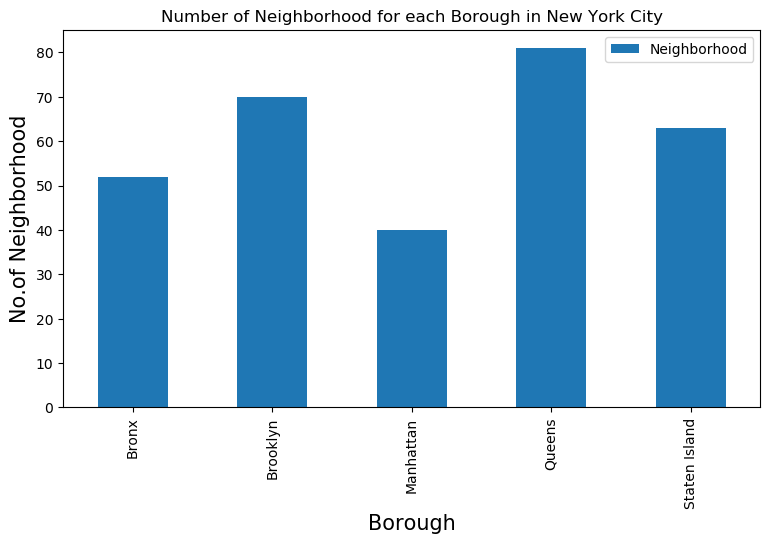

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the highest number of neighborhoods.

Now we will collect French restaurants for each neighborhood.

In [10]:
! conda create --name test --channel conda-forge python=3.6 basemap
! conda activate test
!python -c "from mpl_toolkits.basemap import Basemap"

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/test

  added / updated specs: 
    - basemap
    - python=3.6


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libpng-1.6.37              |       hed695b0_1         308 KB  conda-forge
    ld_impl_linux-64-2.34      |       h53a641e_5         616 KB  conda-forge
    freetype-2.10.2            |       he06d7ca_0         905 KB  conda-forge
    libblas-3.8.0              |      17_openblas          11 KB  conda-forge
    proj-7.0.0                 |       h966b41f_4         3.7 MB  conda-forge
    libgfortran-ng-7.5.0       |       hdf63c60_6         1.7 MB  conda-forge
    pyshp-2.1.0                |             py_0          31 KB  conda-forge
    python-dateutil-2.8.1      |             py_0         220 KB  conda-forge
    libedit-3.1.20191231       |       h46ee950_0         187 KB  conda-forge
  

In [14]:
# prepare neighborhood list that contains French restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
french_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    french_restaurants=venues[venues['Category']=='French Restaurant']   
    print('(',count,'/',len(new_york_data),')','French Restaurants in '+Neighborhood+', '+Borough+':'+str(len(french_restaurants)))
    for restaurant_detail in french_restaurants.values.tolist():
        id, name , category=restaurant_detail
        french_rest_ny = french_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) French Restaurants in Wakefield, Bronx:0
( 2 / 306 ) French Restaurants in Co-op City, Bronx:0
( 3 / 306 ) French Restaurants in Eastchester, Bronx:0
( 4 / 306 ) French Restaurants in Fieldston, Bronx:0
( 5 / 306 ) French Restaurants in Riverdale, Bronx:0
( 6 / 306 ) French Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) French Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) French Restaurants in Woodlawn, Bronx:0
( 9 / 306 ) French Restaurants in Norwood, Bronx:0
( 10 / 306 ) French Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) French Restaurants in Baychester, Bronx:0
( 12 / 306 ) French Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) French Restaurants in City Island, Bronx:1
( 14 / 306 ) French Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) French Restaurants in University Heights, Bronx:0
( 16 / 306 ) French Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) French Restaurants in Fordham, Bronx:0
( 18 / 306 ) French Restaurants in East Tremont, Bronx:

Now that we have got all the French restaurants in New York City , we will analyze the collected data.

In [15]:
french_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
4,Brooklyn,Greenpoint,5429c4d6498ec21e380dd97f,Le Fond


In [16]:
french_rest_ny.shape

(73, 4)

According to the data analysis, we have 73 French restaurants spread across New York City. But which borough are they most concentrated in?

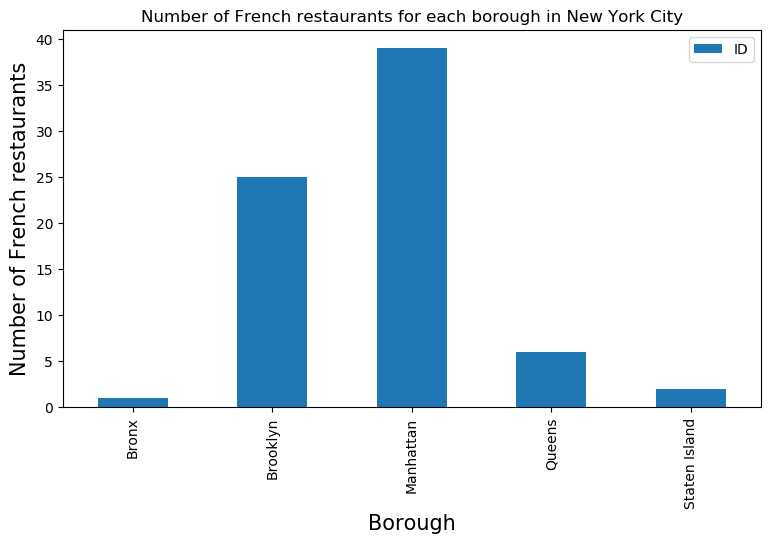

In [18]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French restaurants for each borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of French restaurants', fontsize=15)
#giving a bar plot
french_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Manhattan clearly has the most French restaurants, followed by Brooklyn. The number of French restaurants in other boroughs drops drastically, from 25 in Brooklyn to 6 in Queens.

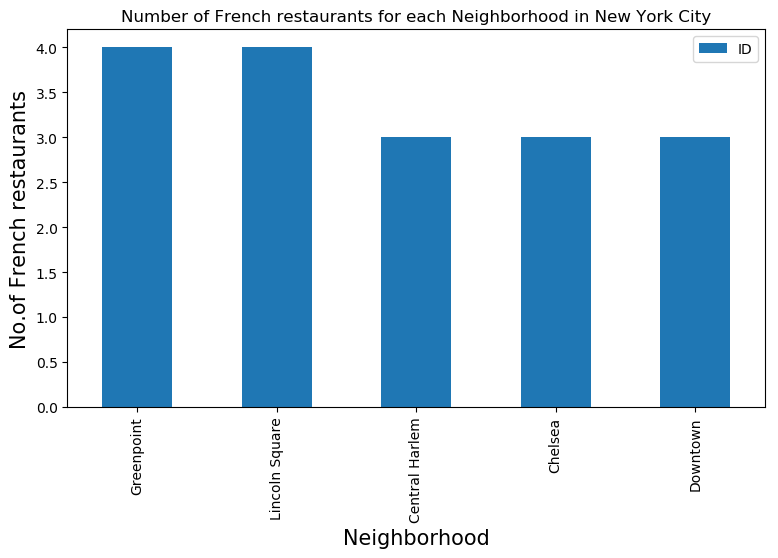

In [20]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of French restaurants', fontsize=15)
#giving a bar plot
french_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Greenpoint seems to have the largest number of French restaurants.

In [21]:
french_rest_ny[french_rest_ny['Neighborhood']=='Greenpoint']

,Borough,Neighborhood,ID,Name
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
4,Brooklyn,Greenpoint,5429c4d6498ec21e380dd97f,Le Fond


So Greenpoint in Brooklyn has the highest number of French restaurants with a total count of 4.
Now we will get the ranking of each restaurant for further analysis.

In [134]:
# prepare neighborhood list that contains French restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
french_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in french_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID) 
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been recently opened or details that do not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(french_rest_ny),')','processed')
    french_rest_stats_ny = french_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

UnboundLocalError: local variable 'CLIENT_ID' referenced before assignment